In [9]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [10]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [11]:
prec = data[0]
evap = data[1]

In [12]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/Fugro_HB28_PB1.xlsx")
df_head = pd.read_excel(file_path_excel)

print(df_head.head())

                 Time  HB28-PB1
0 2023-11-09 11:00:00       NaN
1 2023-11-09 12:00:00       NaN
2 2023-11-09 13:00:00       NaN
3 2023-11-09 14:00:00       NaN
4 2023-11-09 15:00:00       NaN


In [13]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['Time'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['HB28-PB1'].resample("D").mean().dropna()

#### Waterhoogte systeem

In [8]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

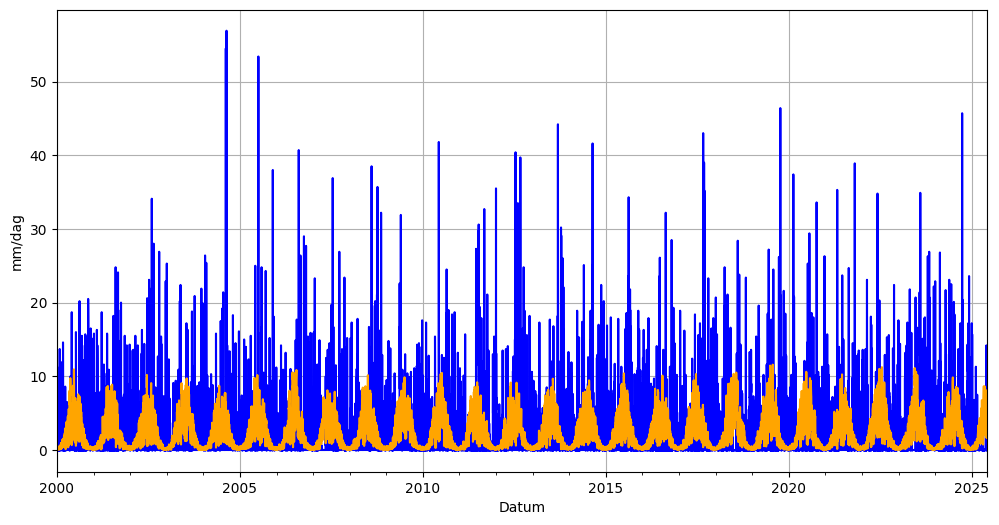

In [14]:
import matplotlib.pyplot as plt

ax1 = prec.plot(label='Precipitation', color='blue', figsize=(12, 6))
ax2 = evap.plot(label='Evaporation', color='orange')
plt.xlabel("Datum")
plt.ylabel("mm/dag")  # or your preferred unit
plt.grid(True)
plt.show()

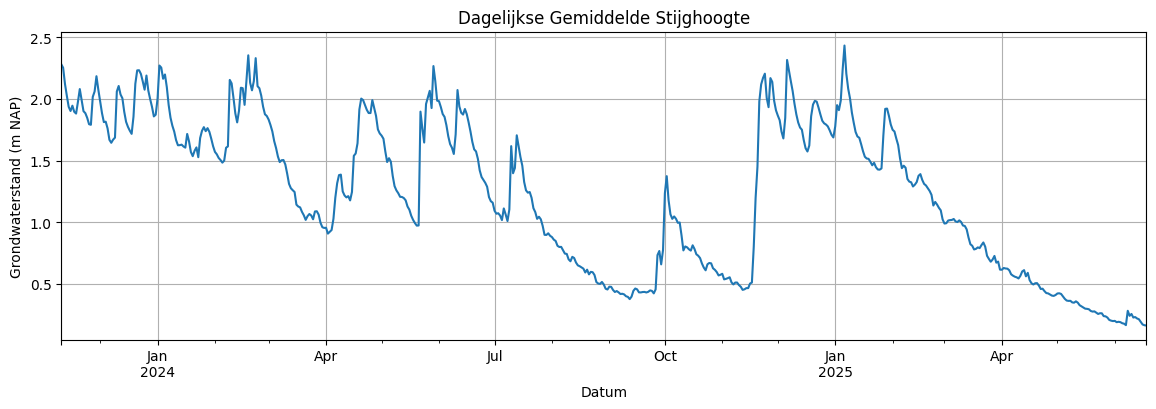

In [15]:
head_daily_mean.plot(figsize=(14, 4), title="Dagelijkse Gemiddelde Stijghoogte")
plt.xlabel("Datum")
plt.ylabel("Grondwaterstand (m NAP)")  # or your preferred unit
plt.grid(True)
plt.show()


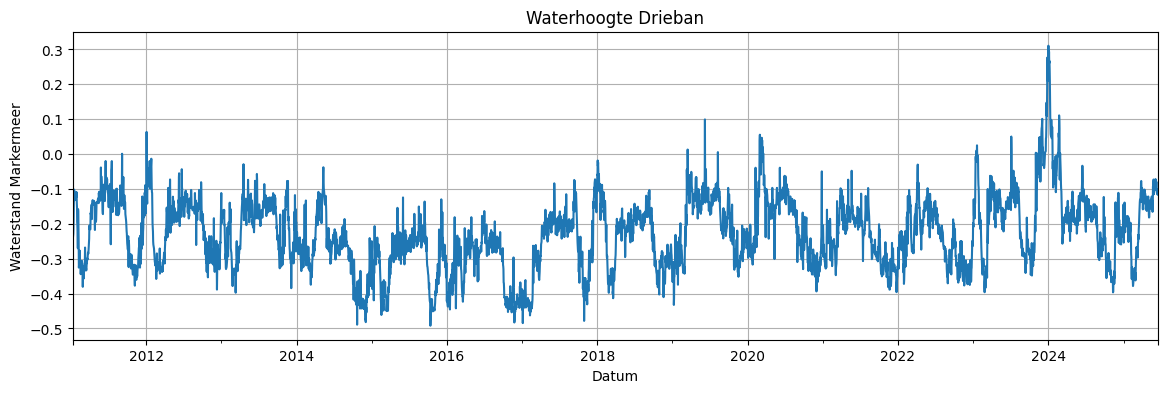

In [16]:
waterhoogte_daily_mean.plot(figsize=(14, 4), title="Waterhoogte Drieban")
plt.xlabel("Datum")
plt.ylabel("Waterstand Markermeer")  # or your preferred unit
plt.grid(True)
plt.show()


In [17]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-11-10 00:00:00 2025-06-18 00:00:00


### Monte Carlo Doen

Running model: Linear_Exponential


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: Linear_Gamma
Running model: Linear_DoubleExponential


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: Linear_Hantush
Running model: Linear_FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: FlexModel_Exponential
Running model: FlexModel_Gamma
Running model: FlexModel_DoubleExponential
Running model: FlexModel_Hantush
Running model: FlexModel_FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Running model: Berendrecht_Exponential
Running model: Berendrecht_Gamma
Running model: Berendrecht_DoubleExponential
Running model: Berendrecht_Hantush
Running model: Berendrecht_FourParam


The integral is probably divergent, or slowly convergent.The integral is probably divergent, or slowly convergent.

Top-performing models:
                            model RechargeModel      RechargeRfunc        EVP  \
2        Linear_DoubleExponential        Linear  DoubleExponential  83.450724   
0              Linear_Exponential        Linear        Exponential  82.003941   
7     FlexModel_DoubleExponential     FlexModel  DoubleExponential  70.667951   
10        Berendrecht_Exponential   Berendrecht        Exponential  65.561738   
12  Berendrecht_DoubleExponential   Berendrecht  DoubleExponential  61.707126   

          R2      RMSE          AIC          BIC  
2   0.834506  0.249091 -2828.145880 -2780.020607  
0   0.820039  0.259751 -2831.001903 -2791.626680  
7   0.699623  0.335584 -2869.546543 -2808.296196  
10  0.654751  0.359777 -2875.581094 -2827.455821  
12  0.611132  0.381829 -2864.772821 -2807.897499  




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


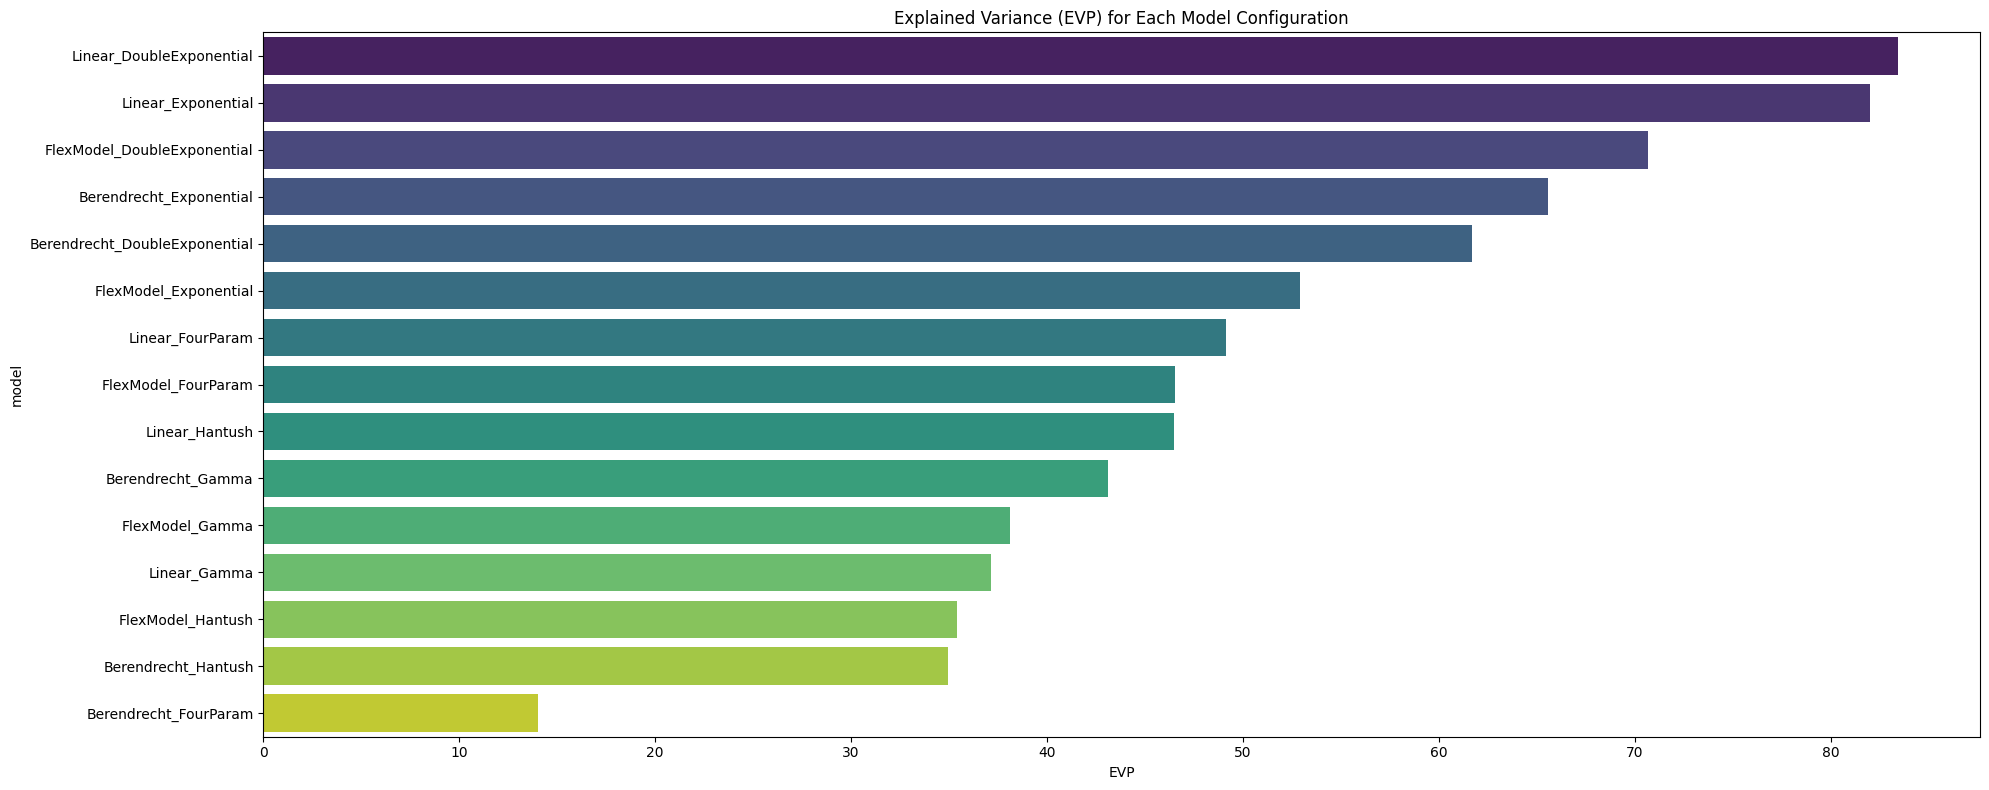

In [27]:
import pastas as ps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define model components
recharge_models = {
    "Linear": ps.rch.Linear(),
    "FlexModel": ps.rch.FlexModel(),
    "Berendrecht": ps.rch.Berendrecht()
}

response_functions = {
    "Exponential": ps.Exponential(),
    "Gamma": ps.Gamma(),
    "DoubleExponential": ps.DoubleExponential(),
    "Hantush": ps.Hantush(),
    "FourParam": ps.FourParam(),
}

# Result containers
results = []
diagnostics_list = []

# Loop over recharge and response function combinations
for rch_name, rch_model in recharge_models.items():
    for rfunc_name, rfunc in response_functions.items():
        model_name = f"{rch_name}_{rfunc_name}"
        print(f"Running model: {model_name}")

        try:
            # 1. Create model
            ml = ps.Model(head_daily_mean, name=model_name)

            # 2. Add recharge stressmodel
            rm = ps.RechargeModel(
                prec=prec,
                evap=evap,
                recharge=rch_model,
                rfunc=rfunc,
                name="rch"
            )
            ml.add_stressmodel(rm)

            # 3. Add extra stressor
            extra = ps.StressModel(
                waterhoogte_daily_mean,
                rfunc=ps.FourParam(),
                name="extra",
                settings="prec",
                up=True
            )
            ml.add_stressmodel(extra)

            # 4. Add noise model
            ml.add_noisemodel(ps.ArNoiseModel())

            # 5. Solve the model
            ml.solve(
                tmin=start_head_series,
                tmax=end_head_series,
                solver=ps.LeastSquares(),
                report=False
            )

            # 6. Store performance metrics
            stats = ml.stats
            results.append({
                "model": model_name,
                "RechargeModel": rch_name,
                "RechargeRfunc": rfunc_name,
                "EVP": stats.evp(),
                "R2": stats.rsq(),
                "RMSE": stats.rmse(),
                "AIC": stats.aic(),
                "BIC": stats.bic()
            })

            # 7. Store diagnostics
            diag_df = ml.stats.diagnostics(alpha=0.05).copy()
            diag_df["model"] = model_name
            diagnostics_list.append(diag_df)

        except Exception as e:
            print(f"Model {model_name} failed: {e}")
            results.append({
                "model": model_name,
                "RechargeModel": rch_name,
                "RechargeRfunc": rfunc_name,
                "EVP": None,
                "R2": None,
                "RMSE": None,
                "AIC": None,
                "BIC": None,
                "error": str(e)
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="EVP", ascending=False)

# Combine diagnostics
if diagnostics_list:
    diagnostics_df = pd.concat(diagnostics_list).reset_index()
    diagnostics_df.rename(columns={"index": "Test"}, inplace=True)
    diagnostics_df = diagnostics_df[["model", "Test", "Checks", "Statistic", "P-value", "Reject H0 ($\\alpha$=0.05)"]]
else:
    diagnostics_df = pd.DataFrame()

# Display top results
print("Top-performing models:")
print(results_df.head())

# Optional: plot
plt.figure(figsize=(20, 8))
sns.barplot(data=results_df, y="model", x="EVP", palette="viridis")
plt.title("Explained Variance (EVP) for Each Model Configuration")
plt.tight_layout()
plt.show()


In [19]:
results_df

,model,RechargeModel,RechargeRfunc,EVP,R2,RMSE,AIC,BIC
2,Linear_DoubleExponential,Linear,DoubleExponential,82.136725,0.821362,0.258794,-2834.559409,-2803.934235
0,Linear_Exponential,Linear,Exponential,74.222752,0.740905,0.311671,-2832.473065,-2810.597941
7,FlexModel_DoubleExponential,FlexModel,DoubleExponential,71.876148,0.718756,0.324720,-2888.772999,-2845.022751
12,Berendrecht_DoubleExponential,Berendrecht,DoubleExponential,67.783945,0.677789,0.347566,-2883.767147,-2844.391923
10,Berendrecht_Exponential,Berendrecht,Exponential,65.676542,0.654815,0.359744,-2881.861880,-2851.236706
4,Linear_FourParam,Linear,FourParam,46.561883,0.460023,0.449940,-2699.944731,-2669.319558
14,Berendrecht_FourParam,Berendrecht,FourParam,46.217121,0.458082,0.450748,-2698.529963,-2659.154739
9,FlexModel_FourParam,FlexModel,FourParam,42.610805,0.420579,0.466084,-2692.972344,-2649.222096
11,Berendrecht_Gamma,Berendrecht,Gamma,40.032446,0.385809,0.479865,-2859.027933,-2824.027734
5,FlexModel_Exponential,FlexModel,Exponential,37.746054,0.363233,0.488605,-2894.452901,-2859.452702


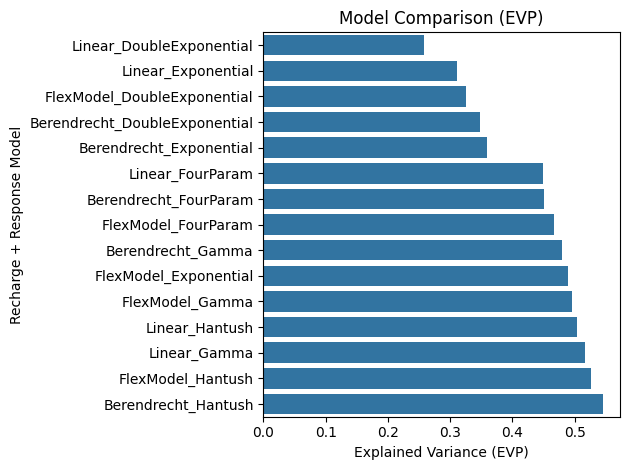

In [20]:
sns.barplot(data=results_df, y="model", x="RMSE")
plt.title("Model Comparison (EVP)")
plt.xlabel("Explained Variance (EVP)")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()

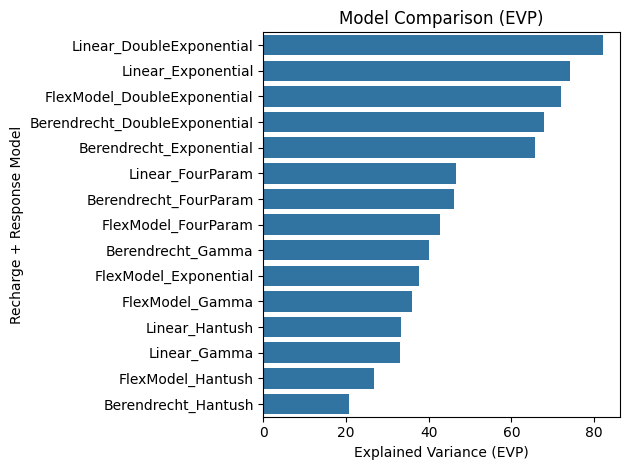

In [21]:
sns.barplot(data=results_df, y="model", x="EVP")
plt.title("Model Comparison (EVP)")
plt.xlabel("Explained Variance (EVP)")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


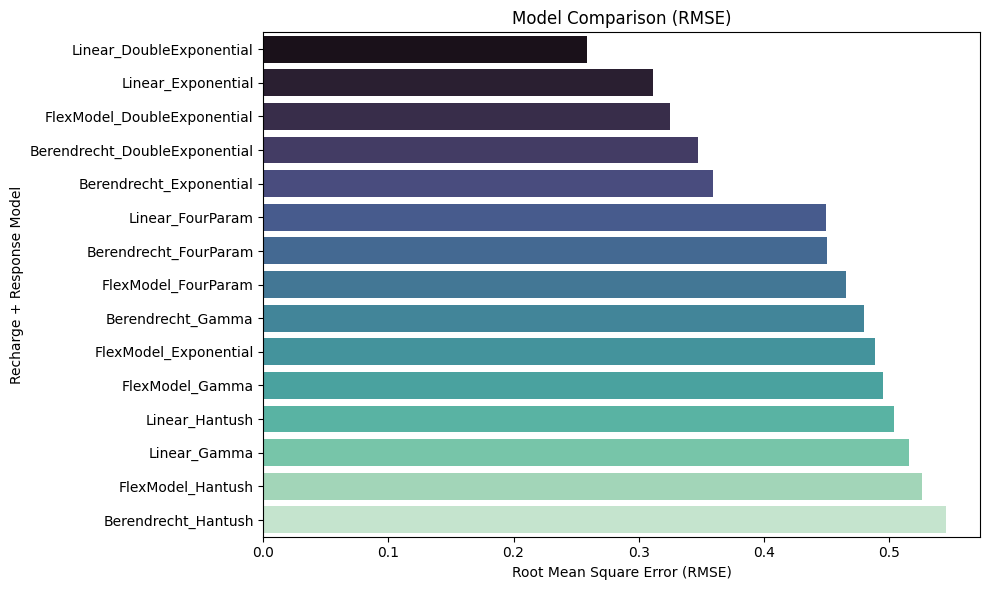

In [22]:
# Plot RMSE separately
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, y="model", x="RMSE", palette="mako")
plt.title("Model Comparison (RMSE)")
plt.xlabel("Root Mean Square Error (RMSE)")
plt.ylabel("Recharge + Response Model")
plt.tight_layout()
plt.show()

In [23]:
diagnostics_df

,model,Test,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
0,Linear_Exponential,Shapiroo,Normality,0.75,0.00,True
1,Linear_Exponential,D'Agostino,Normality,431.52,0.00,True
2,Linear_Exponential,Runs test,Autocorr.,-5.91,0.00,True
3,Linear_Exponential,Ljung-Box,Autocorr.,21.18,0.10,False
4,Linear_Exponential,Durbin-Watson,Autocorr.,1.93,nan,False
...,...,...,...,...,...,...
70,Berendrecht_FourParam,Shapiroo,Normality,0.66,0.00,True
71,Berendrecht_FourParam,D'Agostino,Normality,530.10,0.00,True
72,Berendrecht_FourParam,Runs test,Autocorr.,-5.08,0.00,True
73,Berendrecht_FourParam,Ljung-Box,Autocorr.,42.53,0.00,True


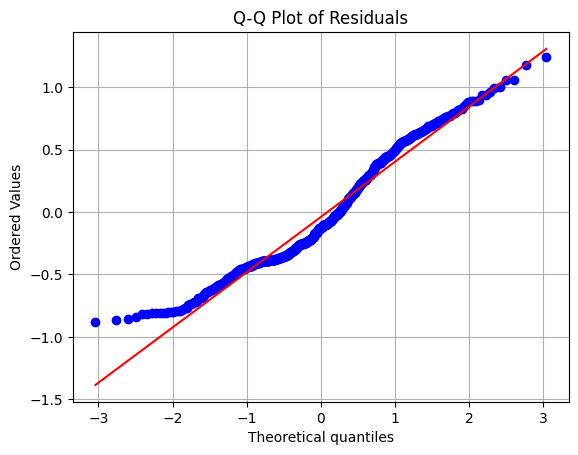

In [24]:
from scipy import stats
import matplotlib.pyplot as plt

residuals = ml.residuals()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

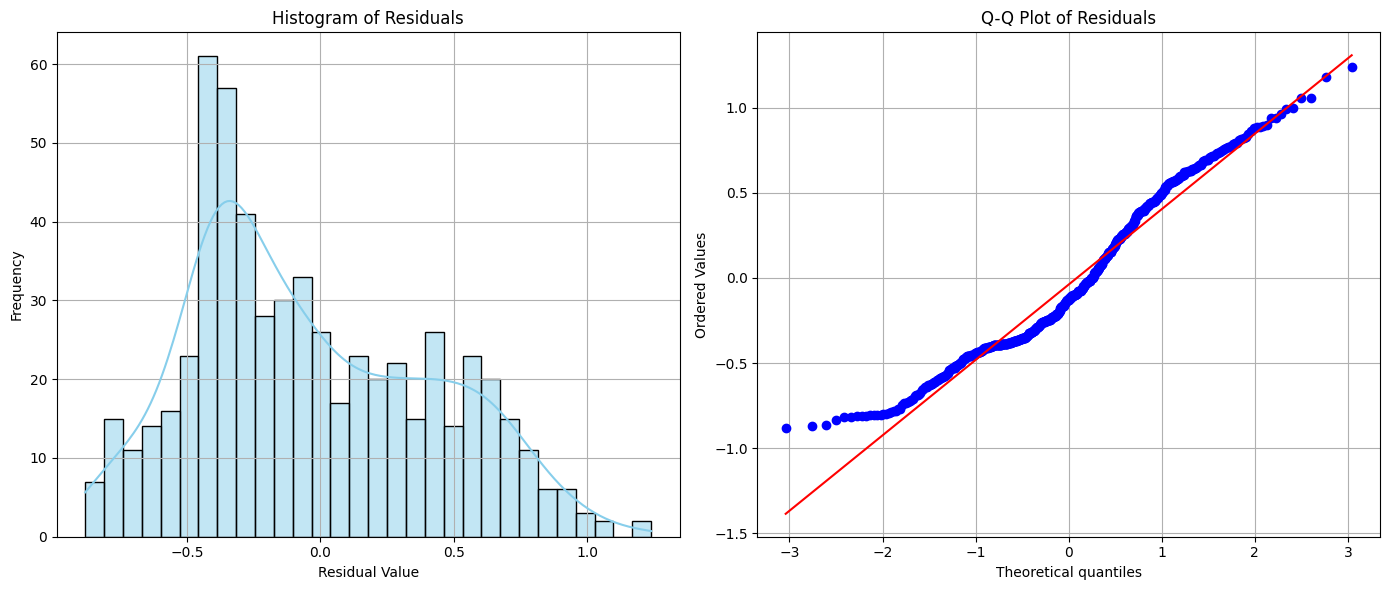

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Get residuals from the model
residuals = ml.residuals()

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 1. Histogram with kernel density estimate (KDE)
sns.histplot(residuals, bins=30, kde=True, ax=axs[0], color="skyblue")
axs[0].set_title("Histogram of Residuals")
axs[0].set_xlabel("Residual Value")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axs[1])
axs[1].set_title("Q-Q Plot of Residuals")
axs[1].grid(True)

plt.tight_layout()
plt.show()
